In [1]:
import pandas as pd
import numpy as np 
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('/home/takaya/Downloads/data/quora_features.csv')#[:100]

In [3]:
features = list(set(train.columns) - set(['id', 'question1', 'question2', 'is_duplicate']))

In [10]:
features

['skew_q1vec',
 'canberra_distance',
 'cosine_distance',
 'minkowski_distance',
 'cityblock_distance',
 'jaccard_distance',
 'euclidean_distance',
 'kur_q2vec',
 'len_word_q2',
 'len_char_q1',
 'len_q2',
 'norm_wmd',
 'fuzz_qratio',
 'fuzz_token_set_ratio',
 'len_q1',
 'fuzz_token_sort_ratio',
 'fuzz_WRatio',
 'braycurtis_distance',
 'fuzz_partial_token_set_ratio',
 'len_char_q2',
 'skew_q2vec',
 'fuzz_partial_token_sort_ratio',
 'kur_q1vec',
 'len_word_q1',
 'wmd',
 'fuzz_partial_ratio',
 'common_words',
 'diff_len']

In [4]:
def balance_data_size(x, y):
    x_pos = x[y == 1]
    x_neg = x[y == 0]
    y_pos = y[y == 1]
    y_neg = y[y == 0]
    
#     p = 0.17426778573248283
    p = 0.165
    while len(x_pos) / (len(x_pos) + len(x_neg)) > p:
        x_neg = pd.concat([x_neg, x_neg])
        y_neg = pd.concat([y_neg, y_neg])
    need_negs = int((1 - p) / p * len(x_pos))
    x_neg = x_neg[:need_negs]
    y_neg = y_neg[:need_negs]
  
    x = pd.concat([x_pos, x_neg])
    y = pd.concat([y_pos, y_neg])
    return (x, y)

In [5]:
def split_train_valid_correctly(train):
    new_train_ratio = 0.8

    def normalize_question(s):
        return str(s).lower().strip()

    from collections import defaultdict
    inverted_index = defaultdict(list)
    for index, row in train.iterrows():
        inverted_index[normalize_question(row['question1'])].append(index)
        inverted_index[normalize_question(row['question2'])].append(index)
    len(inverted_index)
    
    import random
    rows = list(train.iterrows())
    random.seed(810)
    random.shuffle(rows)
    new_train_indexes = set()
    for index, row in rows:
        if len(new_train_indexes) >= len(train) * new_train_ratio:
            break

        new_train_indexes.update(inverted_index[normalize_question(row['question1'])])
        new_train_indexes.update(inverted_index[normalize_question(row['question2'])])

    new_valid_indexes = [index for index, row in train.iterrows() if index not in new_train_indexes]

    new_train = train.iloc[list(new_train_indexes)]
    new_valid = train.iloc[list(new_valid_indexes)]

    print('size ratio')
    print(len(new_train_indexes) / len(train))
    print(len(new_valid_indexes) / len(train))

    print('duplicate ratio')
    print(sum(train.is_duplicate) / len(train))
    print(sum(new_train.is_duplicate) / len(new_train))
    print(sum(new_valid.is_duplicate) / len(new_valid))
    
    return (new_train, new_valid)

split_train, split_valid = split_train_valid_correctly(train)

x_train, y_train = balance_data_size(split_train[features], split_train['is_duplicate'])
x_valid, y_valid = balance_data_size(split_valid[features], split_valid['is_duplicate'])

print('balance')
print(sum(y_train) / len(y_train))
print(sum(y_valid) / len(y_valid))

size ratio
0.8
0.2
duplicate ratio
0.369197853026
0.40434156175
0.228623018131
balance
0.165000182945
0.165000535542


In [6]:
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.03
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 10
params["silent"] = 1
params["seed"] = 87978979

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=50, verbose_eval=100) #change to higher #s

[0]	train-logloss:0.677145	valid-logloss:0.676101
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.330139	valid-logloss:0.314725
[200]	train-logloss:0.308126	valid-logloss:0.300521
[300]	train-logloss:0.295992	valid-logloss:0.297717
[400]	train-logloss:0.283164	valid-logloss:0.296031
[500]	train-logloss:0.271266	valid-logloss:0.294889
[600]	train-logloss:0.261599	valid-logloss:0.294338
[700]	train-logloss:0.251741	valid-logloss:0.293852
[800]	train-logloss:0.243928	valid-logloss:0.293482
[900]	train-logloss:0.236654	valid-logloss:0.293299
[1000]	train-logloss:0.229136	valid-logloss:0.293178
[1100]	train-logloss:0.222119	valid-logloss:0.293018
[1200]	train-logloss:0.215676	valid-logloss:0.292935
Stopping. Best iteration:
[1171]	train-logloss:0.217336	valid-logloss:0.292894



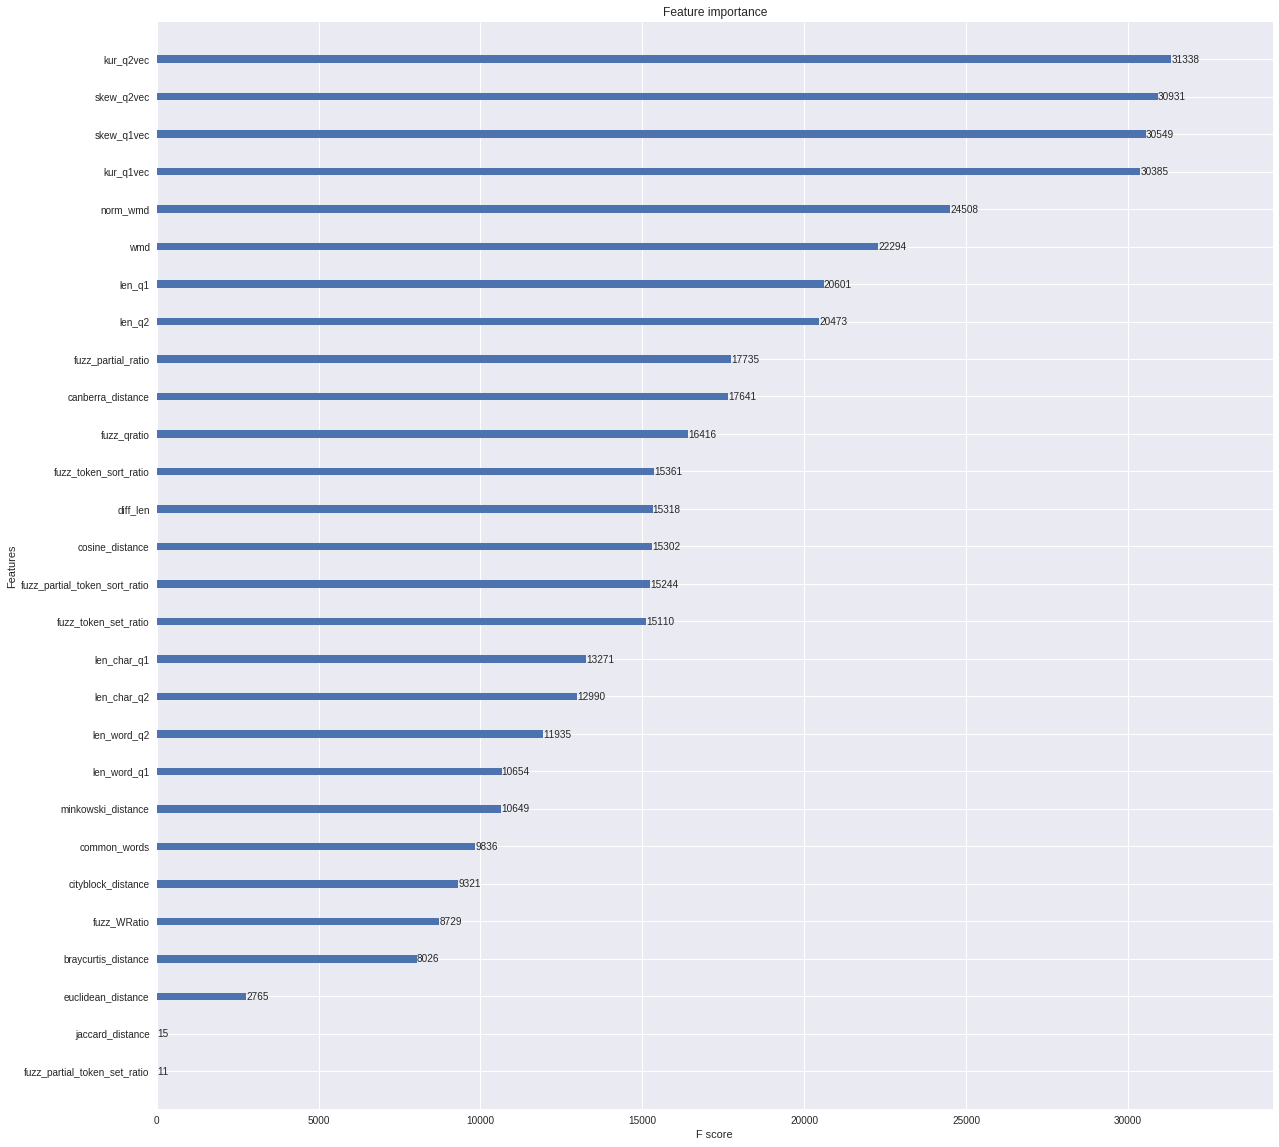

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
xgb.plot_importance(bst); plt.show()

In [8]:
train

,id,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,...,5.081614,1.0,94.023324,0.371408,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,...,14.195119,1.0,177.588090,1.012091,0.455910,0.592655,0.008735,0.094704,0.284010,-0.034444
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,...,9.055989,1.0,135.988707,0.666346,0.307828,0.342306,0.239752,0.144554,0.026759,-0.474131
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26,11,...,15.987437,1.0,192.237828,1.140536,0.506028,0.692421,-0.002527,0.069649,-0.244560,-0.265568
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,...,12.103178,1.0,161.408435,0.860225,0.382770,0.480633,-0.133849,0.114777,0.217900,-0.338876
5,5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,86,90,-4,26,27,16,...,10.254048,1.0,150.335589,0.741946,0.337470,0.400061,0.102946,-0.077741,-0.335505,-0.057847
6,6,Should I buy tiago?,What keeps childern active and far from phone ...,0,19,62,-43,14,20,4,...,17.414754,1.0,200.598725,1.281122,0.597082,0.816676,-0.090366,-0.000266,0.296892,0.130717
7,7,How can I be a good geologist?,What should I do to be a great geologist?,1,30,41,-11,16,16,7,...,5.008762,1.0,95.395891,0.359486,0.161125,0.187150,0.346824,0.368469,0.635773,0.865446
8,8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,31,37,-6,16,16,8,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.202336,0.202336,-0.434927,-0.434927
9,9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,60,49,11,25,24,9,...,10.634987,1.0,153.647611,0.754599,0.337939,0.409126,0.120050,0.204449,-0.214573,-0.126814


In [9]:
test = read_data('test', features)#[:100]
sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = bst.predict(xgb.DMatrix(test[features]))

sub.to_csv('result.csv', index=False)

NameError: name 'read_data' is not defined

In [ ]:
ori_train_pred = bst.predict(xgb.DMatrix(train[features]))
ori_train_bin_pred = np.where(ori_train_pred < 0.5, 0, 1)
print('accuracy: {}'.format(sum(train.is_duplicate == ori_train_bin_pred) / len(train)))

In [ ]:
train_pred = bst.predict(xgb.DMatrix(split_train[features]))
train_bin_pred = np.where(train_pred < 0.5, 0, 1)
print('accuracy: {}'.format(sum(split_train.is_duplicate == train_bin_pred) / len(split_train)))

In [ ]:
valid_pred = bst.predict(xgb.DMatrix(split_valid[features]))
valid_bin_pred = np.where(valid_pred < 0.5, 0, 1)
print('accuracy: {}'.format(sum(split_valid.is_duplicate == valid_bin_pred) / len(split_valid)))

In [ ]:
train['pred'] = ori_train_pred

def calc_score(row):
    return log_loss([row['is_duplicate']], [row['pred']], labels=[0, 1])

train['loss'] = train.apply(calc_score, axis=1)

In [ ]:
text_features = [
    'q1_tokenized',
    'q2_tokenized',
    'question1_nouns',
    'question2_nouns',
    'q1_lemmatized',
    'q2_lemmatized',
    'q1_pos_tagged',
    'q2_pos_tagged',
    'clean_q1_lemmatized_stem',
    'clean_q2_lemmatized_stem'
]

text_features_train = read_feature('train', text_features)

In [ ]:
data = pd.merge(train, text_features_train, how='outer')

In [ ]:
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.max_rows", 101)

In [ ]:
data.sort_values(by='loss', ascending=False)[:1000].to_html('gao.html')

In [ ]:
a = data.iloc[361387]

In [ ]:
a